# Exemple de l'attaque Carlini & Wagner l2 

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

1) Mise en place d'un cnn pour MNIST

In [544]:
# Définir le modèle CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Première couche convolutionnelle (1 canal d'entrée, 32 canaux de sortie, noyau 3x3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Deuxième couche convolutionnelle (32 canaux d'entrée, 64 canaux de sortie, noyau 3x3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Couches entièrement connectées (Aplatissement en 1D puis 10 classes pour la sortie)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # La taille de l'entrée est 64x7x7 après le pooling
        self.fc2 = nn.Linear(128, 10)  # 10 classes pour MNIST (0 à 9)
        
        # Couches de MaxPooling pour réduire les dimensions spatiales
        self.pool = nn.MaxPool2d(2, 2)

        # Couche de Dropout pour la régularisation (éviter le sur-apprentissage)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Appliquer la première couche convolutionnelle suivie de ReLU et MaxPool
        x = self.pool(torch.relu(self.conv1(x)))
        
        # Appliquer la deuxième couche convolutionnelle suivie de ReLU et MaxPool
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Aplatir les données 2D en 1D pour les couches entièrement connectées
        x = x.view(-1, 64 * 7 * 7)  # Aplatir en un vecteur de taille 64 * 7 * 7
        
        # Appliquer la première couche entièrement connectée suivie de ReLU et Dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Appliquer le dropout pour la régularisation
        
        # Couches de sortie avec 10 classes
        x = self.fc2(x)
        
        return x


In [546]:
device = torch.device("cpu")

In [548]:
# Transformations à appliquer aux images du dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
    transforms.Normalize((0.5,), (0.5,))  # Normaliser avec une moyenne et un écart-type de 0.5
])

In [550]:
# Charger le dataset MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [552]:
# Créer les DataLoader pour l'entraînement et les tests
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [554]:
# Initialiser le modèle, la fonction de perte et l'optimiseur
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()  # Pour la classification multi-classes
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [556]:
# Boucle d'entraînement
num_epochs = 1
for epoch in range(num_epochs):
    model.train()  # Mettre le modèle en mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()  # Réinitialiser les gradients avant chaque étape
        
        # Passage avant (forward pass)
        output = model(data)
        
        # Calcul de la perte
        loss = criterion(output, target)
        
        # Passage arrière (backward pass) et optimisation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calcul de la précision
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    # Afficher les statistiques pour chaque époque
    print(f"Époque [{epoch+1}/{num_epochs}], Perte: {running_loss/len(train_loader):.4f}, Précision: {100 * correct/total:.2f}%")


Époque [1/1], Perte: 0.1818, Précision: 94.44%


2) Création de l'attaque

In [624]:
def cw_attack(model, x, y, gamma=1e-3, c_init=1e-2, c_upper=50, b_steps=100, kappa=0.1, lr=1e-3, max_iter=1000):
    # Normalisation de l'entrée
    x_min, x_max = x.min(), x.max()
    x = (x - x_min) / (x_max - x_min)
    x = torch.atanh((2 * x - 1) * gamma)  # Transformation arctanh
    x_adv = x.clone().detach().requires_grad_(True)
    
    # Initialisation des paramètres de recherche binaire
    c_lower, c, c_double = 0, c_init, True
    l_min = float('inf')
    
    # Boucle de recherche binaire
    while b_steps > 0 and c < c_upper:
        x_new = minimize_objective(model, x_adv, x, c, y, kappa, lr, max_iter)  # Minimisation de l'objectif
        
        # Vérification si l'attaque réussit
        with torch.no_grad():
            pred = model(x_new).argmax(dim=1)
        attack_success = (pred == y).all()
        
        if attack_success and torch.norm(x_new - x, p=2).item() < l_min:
            print("success")
            l_min = torch.norm(x_new - x, p=2).item()
            x_adv = x_new.clone()
        
        # Mise à jour du coefficient c
        c, c_double = update_c(c, c_double, attack_success)
        b_steps -= 1
    
    # Transformation inverse
    x_adv = (torch.tanh(x_adv) / gamma + 1) / 2
    x_adv = torch.clamp(x_adv * (x_max - x_min) + x_min, 0, 1)  # S'assurer que x_adv reste dans [0,1]
    
    return x_adv

# Fonction de perte pour forcer la classe cible
def loss_function(x_adv, x, c, y, kappa):
    z = model(x_adv)
    y_pred = z.gather(1, y.view(-1, 1)).squeeze(1)  # Score de la classe cible
    z_other = torch.max(z + (y.view(-1, 1) == torch.arange(z.shape[1], device=x.device)).float() * -1e4, dim=1)[0]  # Max des autres classes
    loss = torch.max(z_other - y_pred + kappa, torch.tensor(0.0, device=x.device)).mean()  # Force y comme prédiction
    return loss + c * torch.norm(x_adv - x, p=2) ** 2  # Régularisation L2
        
# Fonction de minimisation avec Adam
def minimize_objective(model, x_adv, x, c, y, kappa, lr=1e-3, max_iter=500):
    optimizer = torch.optim.Adam([x_adv], lr=lr)
    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = loss_function(x_adv, x, c, y, kappa)
        loss.backward()
        optimizer.step()
        x_adv.data = torch.clamp(x, -1, 1)  # Contrainte pour éviter des valeurs extrêmes
    return x_adv.detach()

# Mise à jour progressive de c
def update_c(c, c_double, success):
    if success:
        c /= 2  # Réduction si l'attaque réussit
    else:
        c *= 2  # Augmentation si l'attaque échoue
    return c, c_double


3) Execution de l'attaque

In [627]:
# Exécution de l'attaque sur une seule image
image, label = next(iter(test_loader))
image, label = image.to(device), label.to(device)

In [629]:
# Génération de l'exemple adversarial 
target_label = 9
adv_image = cw_attack(model, image, torch.tensor([target_label]).to(device))

In [630]:
import matplotlib.pyplot as plt
import numpy as np

In [620]:
# Fonction d'affichage des résultats
def imshow(img, title=""):
    img = img.cpu().detach().numpy().squeeze()
    img = (img - img.min()) / (img.max() - img.min())  # Normalisation pour l'affichage
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

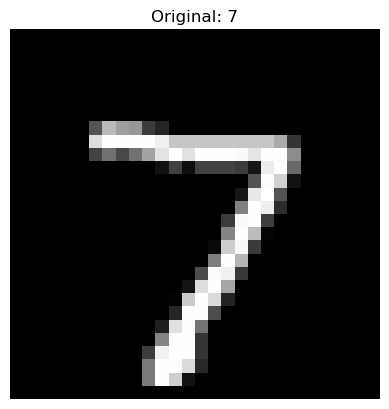

Prédiction initiale : 7


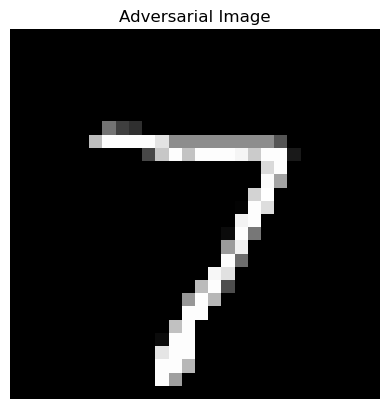

Prédiction après attaque : 7
Probabilités par classe : [[3.3696906e-05 2.8772987e-04 3.7964359e-03 3.4129054e-03 4.1429248e-05
  1.0354547e-05 1.8091919e-07 9.9166334e-01 1.3877836e-04 6.1513344e-04]]


In [622]:
# Afficher l'image originale et l'image attaquée
imshow(image, title=f"Original: {label.item()}")
pred = model(image).argmax(dim=1).item()
print(f"Prédiction initiale : {pred}")

imshow(adv_image, title="Adversarial Image")
pred_adv = model(adv_image).argmax(dim=1).item()
print(f"Prédiction après attaque : {pred_adv}")

with torch.no_grad():
    logits = model(adv_image)  # Obtenir les logits
    probs = F.softmax(logits, dim=1)  # Convertir en probabilités
    print("Probabilités par classe :", probs.cpu().numpy())